<a href="https://colab.research.google.com/github/VMiokova/Project/blob/main/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%80%D1%8B%D0%BD%D0%BA%D0%B0_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D1%85_%D0%B8%D0%B3%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Исследование рынка компьютерных игр для планирования рекламных кампаний </h1>

### Шаг 1. Откроем файл с данными и изучим общую информацию

In [43]:
!pip install missingno

In [44]:
import pandas as pd
from pandas import date_range
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.linear_model import LinearRegression
from matplotlib.table import Table
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from google.colab import drive

In [45]:
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/games.csv', error_bad_lines=False)

print(data.info())
display(data.head(5))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


<ipython-input-45-b6959d682ced>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('/content/drive/My Drive/games.csv', error_bad_lines=False)


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В столбцах Critic_Score, User_Score и Rating есть пропущенные значения.

### Шаг 2. Подготовим данные

Заменим название столбцов, приводя их к нижнему регистру с помощью метода str.lower.

In [46]:
data.columns = data.columns.str.lower()
print(data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


Преобразуем типы данных в столбцах year_of_release, critic_score и user_score.

In [47]:
data['year_of_release'] = data['year_of_release'].astype('Int32')
data['critic_score'] = data['critic_score'].astype('Int32')
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
print(data.head())

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  
0     28.96      3.77         8.45            76         8.0      E  
1      3.58      6.81         0.77          <NA>         NaN    NaN  
2     12.76      3.79         3.29            82         8.3      E  
3     10.93      3.28         2.95            80         8.0      E  
4      8.89     10.22         1.00          <NA>         NaN    NaN  


В столбце year_of_release приводим данные к целочисленному типу, так как год выпуска игры не может быть дробным.

В столбце critic_score приводим данные к целочисленному типу,так как оценка критиков выражается целым числом от 0 до 100, используя тип Int32, который поддерживает пропущенные значения.

В столбце user_score используем функцию to_numeric из библиотеки pandas, чтобы преобразовать данные к числовому типу, так как оценка пользователей выражается дробным числом от 0 до 10. Аргументом errors='coerce' указывам, что некорректные значения (например, строка ‘tbd’) должны быть заменены на NaN.

Обработаем пропуски в столбцах.

In [48]:
missing_values = data.isnull().sum()
print(missing_values)

data = data.dropna(subset=['name', 'genre'])

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


Оценки сами по себе достаточно индивидуальны и субъективны и лучше всего оставим их так как есть.

Визуализируем пропуски.

<Axes: >

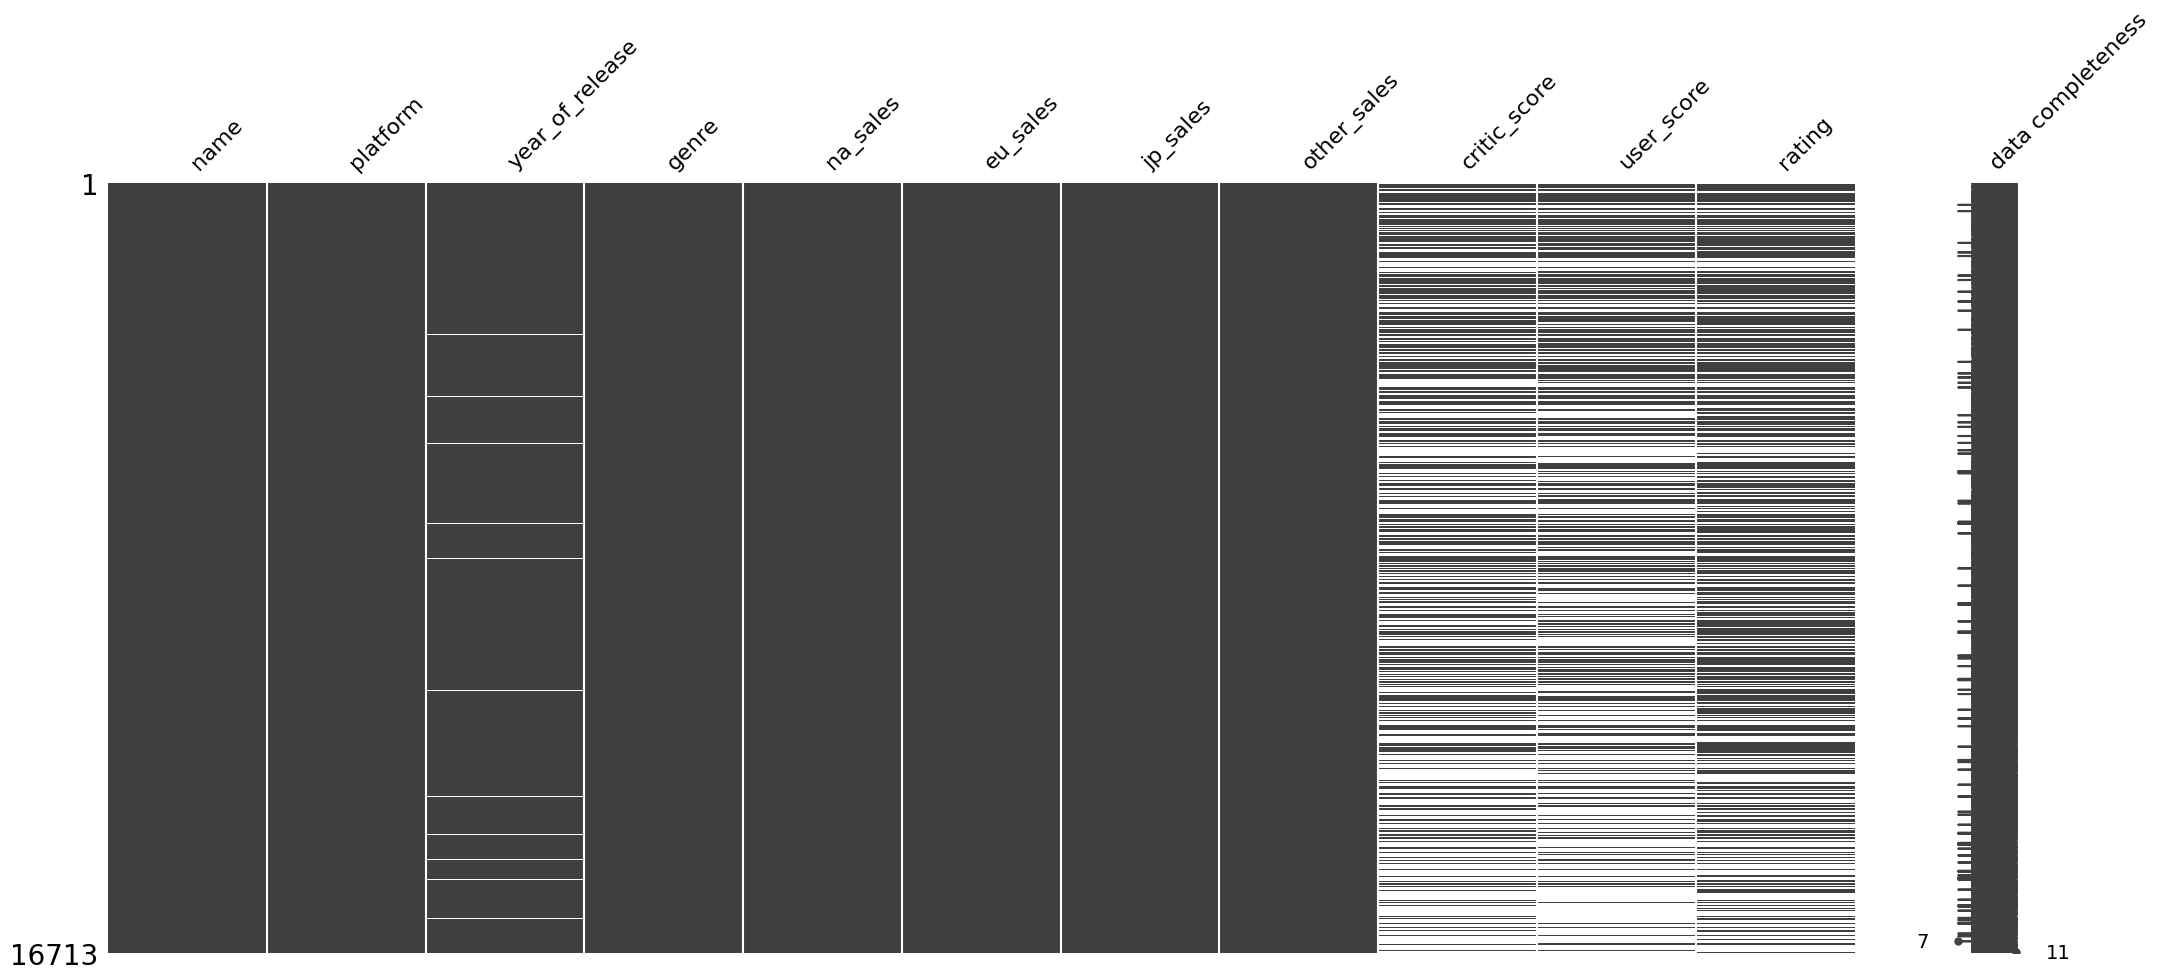

In [49]:
msno.matrix(data, labels=True)

Применим детерминированное регрессионное заполнение к столбцам year_of_release, user_score, rating. Используем класс LinearRegression из библиотеки scikit-learn, чтобы оценить линейную регрессионную модель на основе наблюдаемых значений в целевой переменной и некоторых объясняющих переменных. Затем используем эту модель, чтобы предсказать пропущенные значения в целевой переменной.

In [50]:
X = data[['other_sales', 'na_sales', 'eu_sales', 'jp_sales']]
mask = data['year_of_release'].isnull()
linreg = LinearRegression()
linreg.fit(X[~mask], data.loc[~mask, 'year_of_release'])
predicted_values = linreg.predict(X[mask]).astype(int)
data.loc[mask, 'year_of_release'] = predicted_values

display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN


Порядок категорий в столбце rating важен для вашего анализа. Используем порядковое кодирование (OrdinalEncoder).

In [51]:
rating_order = {
    'EC': 0,   # «Early childhood»
    'K-A': 1,  # «Kids to Adults» (до 1998 года)
    'E': 2,    # «Everyone»
    'E10+': 3, # «Everyone 10 and older»
    'T': 4,    # «Teen»
    'M': 5,    # «Mature»
    'AO': 6    # «Adults Only»
}

data['rating'] = data['rating'].map(rating_order)

Теперь столбец rating содержит числовые коды, которые отражают порядок категорий возрастного рейтинга ESRB.

In [52]:
X = data[['other_sales']]

mask = data['rating'].isnull()

linreg = LinearRegression()
linreg.fit(X[~mask], data.loc[~mask, 'rating'])

data.loc[mask, 'rating'] = linreg.predict(X[mask])

display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,2.000000
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,3.401239
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,2.000000
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,2.000000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,3.464184


In [53]:
X = data[['other_sales', 'year_of_release']]

mask = data['user_score'].isnull()

linreg = LinearRegression()
linreg.fit(X[~mask], data.loc[~mask, 'user_score'])

data.loc[mask, 'user_score'] = linreg.predict(X[mask])

display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.000000,2.000000
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,9.517935,3.401239
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.300000,2.000000
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.000000,2.000000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,8.571879,3.464184


Аббревиатура ‘tbd’ означает ‘To Be Determined’ или ‘Будет определено позже’. Это означает, что оценка пользователей еще не была определена или не была предоставлена.

Обработаем значение 'tbd' в столбце 'user_score', заменяя его на None, затем на среднее значение по столбцу.

In [54]:
data['user_score'] = data['user_score'].replace('tbd', None)

imputer = SimpleImputer(strategy='mean')
data['user_score'] = imputer.fit_transform(data[['user_score']])

display(data['user_score'].head())

0    8.000000
1    9.517935
2    8.300000
3    8.000000
4    8.571879
Name: user_score, dtype: float64

In [55]:
X = data[['other_sales', 'year_of_release']]

mask = data['critic_score'].isnull()

linreg = LinearRegression()
linreg.fit(X[~mask], data.loc[~mask, 'critic_score'])

predicted_values = linreg.predict(X[mask]).astype(int)
data.loc[mask, 'critic_score'] = predicted_values

display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.000000,2.000000
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,76,9.517935,3.401239
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.300000,2.000000
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.000000,2.000000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,79,8.571879,3.464184


Подсчитаем суммарные продажи во всех регионах и запишем их в новый столбец total_sales.

In [56]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
display(data['total_sales'].head())

0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
Name: total_sales, dtype: float64

In [57]:
missing_values = data.isnull().sum()
print(missing_values)

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
dtype: int64


In [58]:
display(data.describe())
display(data.head(5))

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
count,16713.0,16713.000000,16713.000000,16713.000000,16713.000000,16713.0,16713.000000,16713.000000,16713.000000
mean,2006.478191,0.263302,0.145045,0.077625,0.047343,68.547957,7.223911,3.203464,0.533315
std,5.828921,0.813565,0.503359,0.308871,0.186742,9.756961,1.116997,0.877557,1.548282
min,1980.0,0.000000,0.000000,0.000000,0.000000,13.0,0.000000,0.000000,0.000000
25%,2003.0,0.000000,0.000000,0.000000,0.000000,68.0,6.784722,3.000000,0.060000
50%,2007.0,0.080000,0.020000,0.000000,0.010000,68.0,7.250798,3.190507,0.170000
75%,2010.0,0.240000,0.110000,0.040000,0.030000,71.0,7.942960,4.000000,0.470000
max,2016.0,41.360000,28.960000,10.220000,10.570000,98.0,9.713286,6.000000,82.540000


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.000000,2.000000,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,76,9.517935,3.401239,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.300000,2.000000,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.000000,2.000000,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,79,8.571879,3.464184,31.38


На основе данных можно сделать выводы:

Средние продажи игр в Северной Америке выше, чем в других регионах.

Стандартное отклонение продаж игр в Северной Америке также выше, чем в других регионах, что указывает на большее разнообразие в продажах.

Средняя оценка критиков составляет около 69 баллов из 100, а средняя оценка пользователей  - около 7,1 балла из 10.

Большинство игр имеют возрастной рейтинг ESRB 3.

### Шаг 3. Проведем исследовательский анализ данных

Посмотрим сколько игр выпускалось в разные годы. Используем метод groupby объекта DataFrame, чтобы сгруппировать данные по столбцу year_of_release и посчитаем количество игр в каждой группе.

In [59]:
data.groupby('year_of_release')['name'].count().describe()

count      37.000000
mean      451.702703
std       462.423019
min         9.000000
25%        36.000000
50%       338.000000
75%       766.000000
max      1428.000000
Name: name, dtype: float64

Данные охватывают 37 лет.

В среднем в каждый год выпускалось около 452 игр.

Стандартное отклонение составляет около 463, что указывает на значительное разнообразие в количестве выпущенных игр по годам.

Минимальное количество выпущенных игр в один год составляет  9, а максимальное  1427.

Медианное значение составляет 338, что означает в половине лет выпускалось меньше 338 игр, а в другой половине - больше.

Построим график количества выпущенных игр по годам.

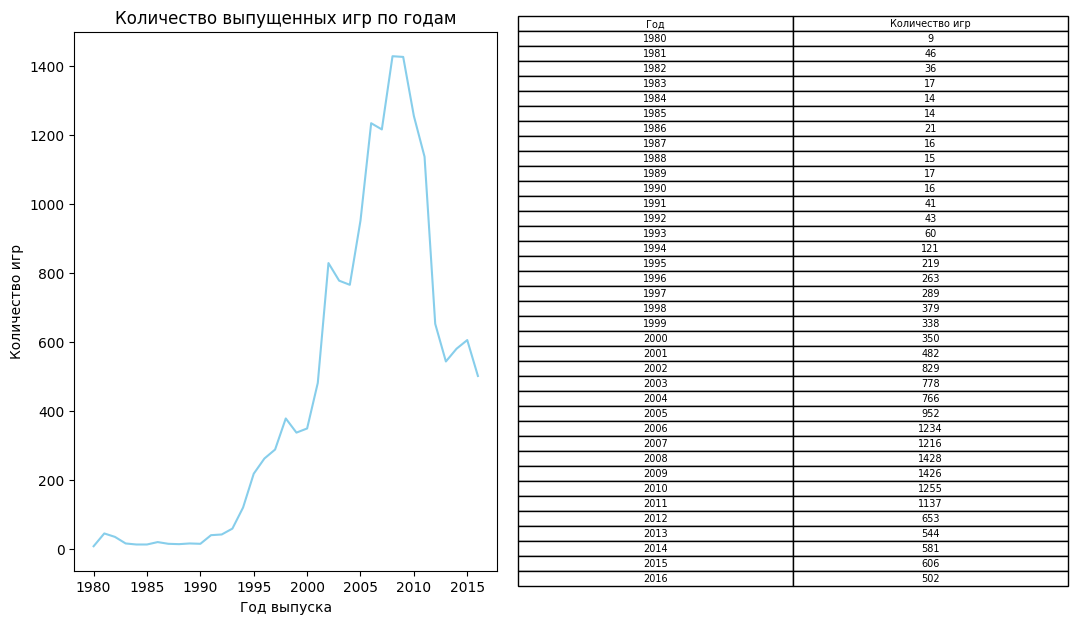

In [60]:
yearly_counts = data.groupby('year_of_release')['name'].count()

fig, axs = plt.subplots(1, 2, figsize=(12, 7))

yearly_counts.plot(ax=axs[0], color='skyblue')
axs[0].set_xlabel('Год выпуска')
axs[0].set_ylabel('Количество игр')
axs[0].set_title('Количество выпущенных игр по годам')

table_data = [['Год', 'Количество игр']] + list(yearly_counts.reset_index().values)
table = axs[1].table(cellText=table_data, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(1.3, 0.9)

axs[1].axis('off')

plt.show()

Пик выпуска игор просматривается с начала 2000-х по 2012гг.

Вычислим корреляцию между количеством выпущенных игр и другими показателями.

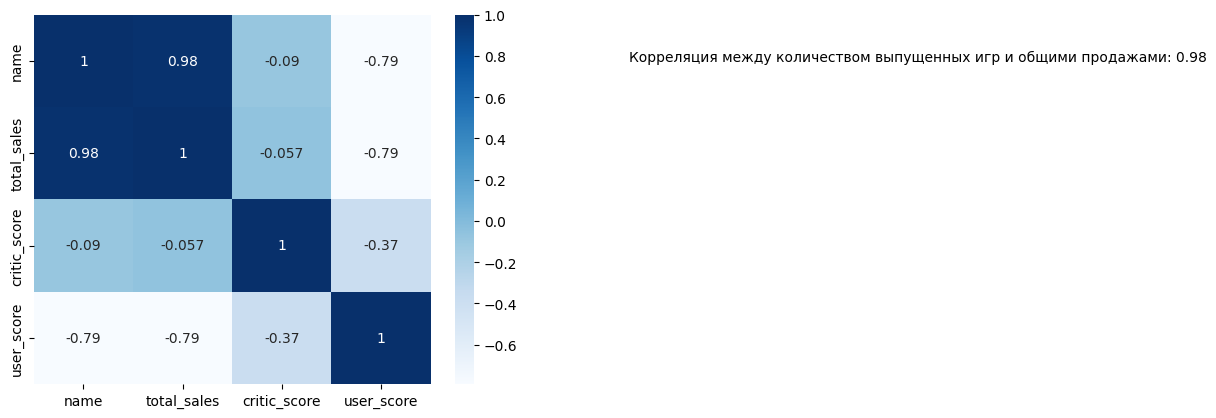

In [61]:
yearly_data = data.groupby('year_of_release').agg({
    'name': 'count',
    'total_sales': 'sum',
    'critic_score': 'mean',
    'user_score': 'mean'
})

corr = yearly_data.corr()

corr_value = corr.loc['name', 'total_sales']
sns.heatmap(corr, annot=True, cmap='Blues')


plt.text(6, 0.5, f"Корреляция между количеством выпущенных игр и общими продажами: {corr_value:.2f}")
plt.show()

Коэффициент корреляции между количеством выпущенных игр и общими продажами = 0.98, это указывает на сильную прямую линейную зависимость между показателями.

В годы, когда выпускалось больше игр, общие продажи также были выше, и наоборот.

Посмотрим, как менялись продажи по платформам. Сгруппируем данные по платформе и году выпуска и вычислим сумму продаж для каждой группы. На графике отобразим изменение продаж по платформам со временем.

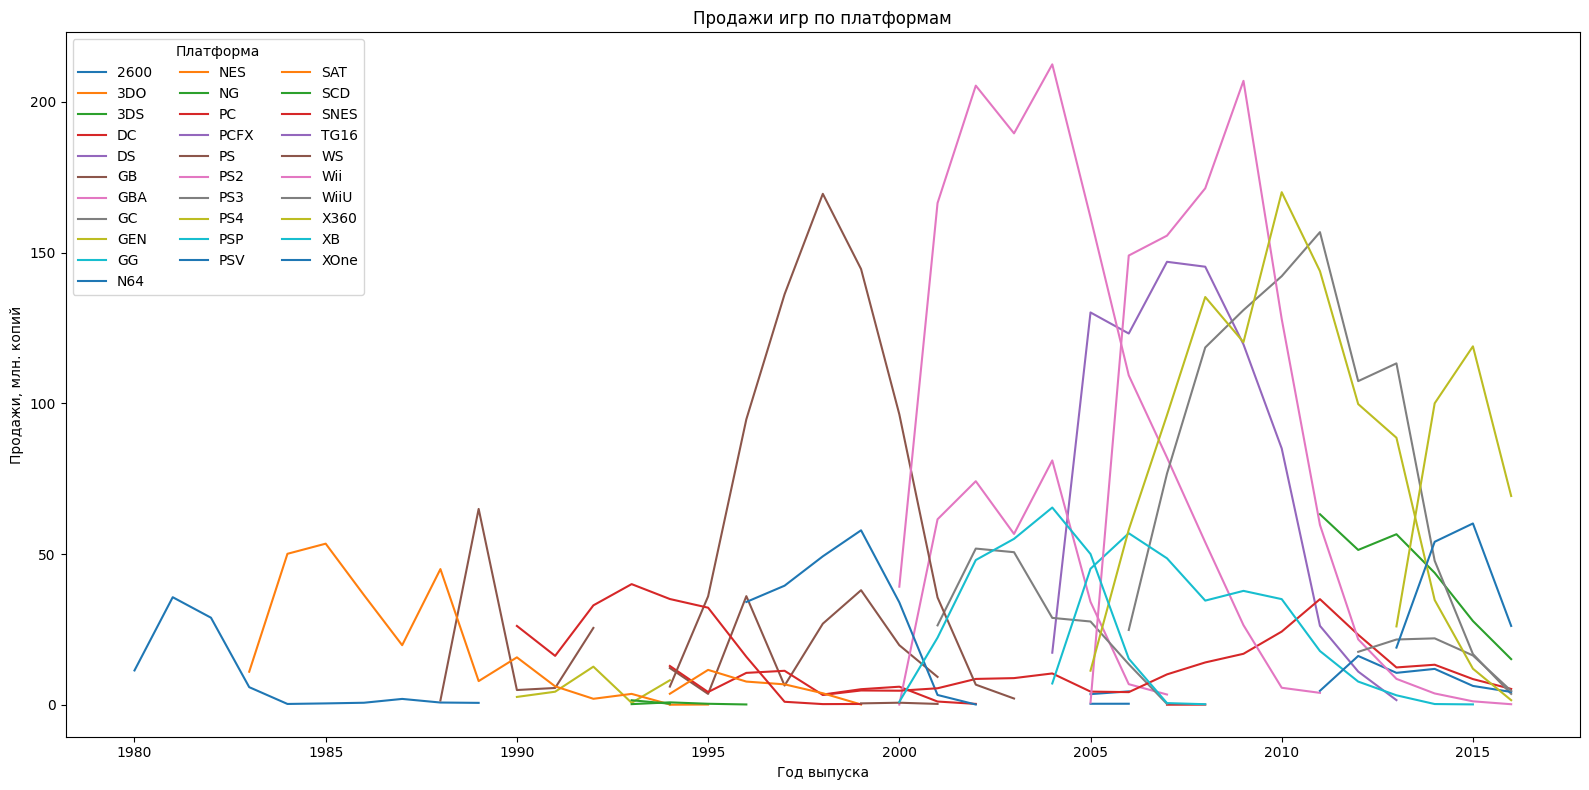

In [62]:
platform_sales = data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

fig, ax = plt.subplots(figsize=(16, 8))
platform_sales.plot(ax=ax)
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Продажи, млн. копий')
ax.set_title('Продажи игр по платформам')
legend = ax.legend(loc='upper left', ncol=3)

ax.tick_params(axis='both', labelsize=10)
legend.set_title('Платформа', prop={'size': 10})
for text in legend.get_texts():
    text.set_fontsize(10)

plt.tight_layout()
plt.show()

Проанализируем данные о продажах игр по платформам и годам:

1. Тенденция продаж по годам:
- Данные охватывают продажи с 1980 по 2016 год.
- В целом наблюдается снижение продаж для старых платформ, таких как SAT, SCD, SNES, TG16, WS и XB. Это вполне ожидаемо, поскольку эти платформы были активны в более ранние годы и были вытеснены более новыми платформами.
- Платформы, вышедшие относительно недавно (PS3, PS4, PSP, PSV, Wii, WiiU, X360, XB, XOne), имеют более высокие средние продажи по сравнению со старыми платформами.

2. Платформенные показатели (на основе среднего значения total_sales):
- Платформы PS4, X360 и PS3 имеют самые высокие средние продажи, что говорит о том, что они являются наиболее популярными и успешными платформами с точки зрения продаж игр.
- Платформы TG16, SCD, WS, SAT, PSV и XB имеют относительно более низкие средние продажи, что говорит о том, что они, возможно, не столь успешны с коммерческой точки зрения.

3. Разброс продаж по платформам (на основе стандартного отклонения total_sales):
- Платформы с более высокими стандартными отклонениями, такие как PS3, PS4 и X360, характеризуются большей вариативностью продаж, что говорит о более широком диапазоне продаж игр для этих платформ.
- Платформы с более низкими стандартными отклонениями, такие как WS, SAT, TG16 и SNES, имеют более стабильные продажи, что означает, что продажи игр для них более стабильны.

4. Продажи в зависимости от года выпуска:
- В среднем суммарные продажи новых платформ выше, чем старых, что вполне ожидаемо, поскольку игровая индустрия со временем развивается и привлекает все больше потребителей.

5. Самые продаваемые игры:
- Данные не содержат конкретной информации об отдельных играх, но было бы важно проанализировать самые продаваемые игры для каждой платформы.

6. Жизненный цикл платформы:
- Некоторые платформы, такие как PS3, X360 и Wii, имеют относительно долгую историю продаж, что, вероятно, связано с их длительным жизненным циклом, в то время как у других он короче, что и сказывается на их общих продажах.

7. Доля рынка:
- Для получения дополнительной информации было бы полезно сравнить долю рынка каждой платформы с течением времени. Это поможет понять относительное доминирование различных платформ в игровой индустрии.

8. Факторы, зависящие от конкретной платформы:
- Успех каждой платформы зависет от различных факторов, таких как эксклюзивные игры, аппаратные возможности, цена, маркетинговые усилия и конкуренция со стороны других платформ.


In [63]:
platform_year_sales = data.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
peak_sales = platform_year_sales.loc[platform_year_sales.groupby('platform')['total_sales'].idxmax()]

grouped = data.groupby('platform')
for platform, group in grouped:
    print(f'Platform: {platform}')
    print(group[['year_of_release', 'total_sales']].describe())

Platform: 2600
       year_of_release  total_sales
count            133.0   133.000000
mean       1985.142857     0.729173
std            8.09989     0.917799
min             1980.0     0.070000
25%             1981.0     0.300000
50%             1982.0     0.460000
75%             1983.0     0.780000
max             2006.0     7.810000
Platform: 3DO
       year_of_release  total_sales
count              3.0     3.000000
mean       1994.666667     0.033333
std            0.57735     0.023094
min             1994.0     0.020000
25%             1994.5     0.020000
50%             1995.0     0.020000
75%             1995.0     0.040000
max             1995.0     0.060000
Platform: 3DS
       year_of_release  total_sales
count            520.0   520.000000
mean       2013.017308     0.498077
std           1.855494     1.430876
min             2006.0     0.010000
25%             2012.0     0.050000
50%             2013.0     0.120000
75%             2015.0     0.330000
max             2016.

Проанализируем данные о продажах игр для платформ :

2600 Платформа:
В данных содержится 133 игры для платформы 2600.
Общее количество проданных копий составляет около 96,957 млн.
Средний объем продаж игр для платформы 2600 составляет около 729 тыс. копий.
Стандартное отклонение продаж составляет примерно 918 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 70 тыс. экземпляров, а максимальный - 7,81 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе 2600 были проданы тиражом менее 0,3 млн. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 0,46 млн. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 0,78 млн. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

Платформа 3DO:
Для платформы 3DO в данных присутствует всего 3 игры.
Общее количество проданных копий для этих трех игр составляет 100 тыс.
Среднее значение продаж игр на платформе 3DO составляет примерно 33,333 тыс. копий.
Стандартное отклонение продаж составляет примерно 23,094 тыс. экземпляров, что говорит о том, что продажи игр на этой платформе также имеют некоторый разброс вокруг среднего значения.
Минимальный объем продаж игры на этой платформе составляет 20 тыс. экземпляров, а максимальный - 60 тыс. экземпляров.
25% игр на платформе 3DO продались тиражом менее 20 тыс. экземпляров, что говорит о том, что четверть игр имела более низкие продажи.
Медианное значение (50-й процентиль) также продано менее 20 тыс. копий, что говорит о том, что половина игр находится ниже этого порога продаж.
75% игр на платформе 3DO продались тиражом менее 40 тыс. экземпляров, что говорит о том, что большинство игр на этой платформе достигли скромных продаж.

Платформа 3DS:
Для платформы 3DS в данных содержится 520 игр.
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр на платформе 3DS составляет около 498 тыс. копий.
Стандартное отклонение продаж составляет примерно 1,431 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 14,6 млн. экземпляров, что свидетельствует о широком диапазоне показателей продаж.
25% игр на платформе 3DS были проданы тиражом менее 50 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 120 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продались тиражом менее 330 тыс. экземпляров, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

Платформа DC:
Для платформы Dreamcast (DC) в данных содержится 52 игры.
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр на платформе Dreamcast составляет около 306 тыс. копий.
Стандартное отклонение продаж составляет примерно 468 тыс. экземпляров, что свидетельствует о том, что продажи игр отличаются от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 20 тыс. экземпляров, а максимальный - 2,41 млн. экземпляров.
25% игр на платформе Dreamcast были проданы тиражом менее 77,5 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 135 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продались тиражом менее 297,5 тыс. экземпляров, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

Платформа DS:
Для платформы DS в данных содержится 2151 игра.
Общее количество проданных копий для этих игр не приводится.
этих игр не приводится.
Средний объем продаж игр для платформы DS составляет около 375 тыс. экземпляров.
Стандартное отклонение продаж составляет примерно 1,427 млн. экземпляров, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 29,8 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе DS были проданы тиражом менее 50 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 110 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продались тиражом менее 270 тыс. экземпляров, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

Платформа GB:
В данных содержится 98 игр для платформы Game Boy (GB).
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр для платформы GB составляет около 2,607 млн. копий.
Стандартное отклонение продаж составляет примерно 5,365 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 60 тыс. экземпляров, а максимальный - 31,38 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе GB продались тиражом менее 302,5 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 1,165 млн. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продались тиражом менее 2,165 млн. копий, что свидетельствует о том, что значительная часть игр достигла на этой платформе умеренных или высоких продаж.

Платформа GBA:
Для платформы Game Boy Advance (GBA) в данных содержится 822 игры.
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр для платформы GBA составляет около 387 тыс. копий.
Стандартное отклонение продаж составляет примерно 897 тыс. экземпляров, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 15,84 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе GBA продались тиражом менее 52.5 тыс. экземпляров, что говорит о том, что четверть игр имела более низкие продажи.
Медианное значение продано менее 160 тыс. копий, что говорит о том, что половина игр находится ниже этого порога продаж.
75% игр на платформе продались тиражом менее  15,84 млн. экземпляров, что говорит о том, что значительная часть игр достигла на этой платформе умеренных или высоких продаж.

Платформа GC:
В данных содержится 556 игр для платформы GameCube (GC).
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр для платформы GC составляет около 358 тыс. копий.
Стандартное отклонение продаж составляет примерно 686 тыс. копий, что свидетельствует о том, что продажи игр отличаются от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 7,06 млн. экземпляров.
25% игр на платформе GC продались тиражом менее 60 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 150 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продалось менее 352,5 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

Платформа GEN:
Для платформы Genesis (GEN) в данных представлено 29 игр.
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр на платформе GEN составляет около 1,061 млн. копий.
Стандартное отклонение продаж составляет примерно 1,471 млн. копий, что свидетельствует о том, что продажи игр отличаются от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 30 тыс. экземпляров, а максимальный - 6,02 млн. экземпляров.
25% игр на платформе GEN продались тиражом менее 70 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 150 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продались тиражом менее 1,76 млн. копий, что свидетельствует о том, что значительная часть игр достигла на этой платформе умеренных или высоких продаж.

Платформа GG:
В данных присутствует только одна игра для платформы Game Gear (GG).
Общее количество проданных копий для этой игры не приводится.
Средний объем продаж игр на платформе GG составляет около 40 тыс. экземпляров.
Поскольку в данных присутствует только одна игра, стандартное отклонение продаж рассчитать невозможно.
Минимальный объем продаж для игры на этой платформе составляет 40 тыс. экземпляров, а максимальный - также 40 тыс. экземпляров, поскольку имеется только одна точка данных.

Платформа N64:
Для платформы Nintendo 64 (N64) в данных содержится 319 игр.
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр для платформы N64 составляет около 686 тыс. копий.
Стандартное отклонение продаж составляет примерно 1,317 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 11,9 млн. экземпляров.
25% игр на платформе N64 продались тиражом менее 135 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 270 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продались тиражом менее 595 тыс. экземпляров, что свидетельствует о том, что значительная часть игр достигла на этой платформе умеренных или высоких продаж.

Платформа NES: Для платформы Nintendo Entertainment System (NES) в данных представлено 98 игр.
Общее количество проданных копий для этих игр не приводится.
Средний объем продаж игр для платформы NES составляет около 2,562 млн. копий.
Стандартное отклонение продаж составляет примерно 5,108 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 60 тыс. экземпляров, а максимальный - 40,24 млн. экземпляров.
25% игр на платформе NES были проданы тиражом менее 1 млн. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 1,375 млн. копий, что свидетельствует о том, что половина игр попадает в категорию относительно низких продаж.
что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 2,223 млн. копий, что свидетельствует о том, что значительная часть игр достигла умеренных или высоких продаж на этой платформе.

Платформа NG: Для платформы Neo Geo (NG) в данных содержится 12 игр.
Общее количество проданных копий составляет около 1.44 млн.
Средний объем продаж игр для платформы NG составляет около 120 тыс. копий.
Стандартное отклонение продаж составляет примерно 82 тыс. экземпляров, что свидетельствует о том, что продажи игр отличаются от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 20 тыс. экземпляров, а максимальный - 250 тыс. экземпляров, что свидетельствует о небольшом диапазоне продаж.
25% игр на платформе NG были проданы тиражом менее 55 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 100 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 200 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

PC Платформа: В данных содержится 974 игры для платформы PC. Общее количество проданных копий составляет около 259 млн. Средний объем продаж игр для платформы PC составляет около 266.448 тыс. копий. Стандартное отклонение продаж составляет примерно 675.577 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 8.01 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе PC были проданы тиражом менее 20 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 50 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 170 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.


PCFX Платформа: В данных содержится всего одна игра для платформы PCFX с объемом продаж в размере 30
тысяч копий.


PS Платформа: В данных содержится 1197 игр для платформы PS. Общее количество проданных копий составляет около 731 млн. Средний объем продаж игр для платформы PS составляет около 610.576 тыс. копий. Стандартное отклонение продаж составляет примерно 1.054502 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 10.95 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе PS были проданы тиражом менее 110 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 260 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 660 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

PS2 Платформа: В данных содержится 2161 игра для платформы PS2. Общее количество проданных копий составляет около 1255 млн. Средний объем продаж игр для платформы PS2 составляет около 581.106 тыс. копий. Стандартное отклонение продаж составляет примерно 1.137927 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 0 копий, а максимальный - 20.81 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе PS2 были проданы тиражом менее 80 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 230 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 560 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

PS3 Платформа: В данных содержится 1331 игра для платформы PS3. Общее количество проданных копий составляет около 939 млн. Средний объем продаж игр для платформы PS3 составляет около 705.973 тыс. копий. Стандартное отклонение продаж составляет примерно 1.391749 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 0 копий, а максимальный - 21.05 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе PS3 были проданы тиражом менее 110 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 270 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 750 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

PS4 Платформа:
В данных содержится 392 игры для платформы PS4.
Общее количество проданных копий составляет около 314 млн.
Средний объем продаж игр для платформы PS4 составляет около 801.378 тыс. копий.
Стандартное отклонение продаж составляет примерно 1.609456 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 14.63 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе PS4 были проданы тиражом менее 60 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 200 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 730 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

PSP Платформа:
В данных содержится 1209 игр для платформы PSP.
Общее количество проданных копий составляет около 294 млн.
Средний объем продаж игр для платформы PSP составляет около 243.218 тыс. копий.
Стандартное отклонение продаж составляет примерно 520.210 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 7.68 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе PSP были проданы тиражом менее 30 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 90 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 230 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

PSV Платформа:
В данных содержится 430 игр для платформы PSV.
Общее количество проданных копий составляет около 54 млн.
Средний объем продаж игр для платформы PSV составляет около 125.744 тыс. копий.
Стандартное отклонение продаж составляет примерно 212.193 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 1.96 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе PSV были проданы тиражом менее 20 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 55 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 130 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

SAT Платформа:
В данных содержится 173 игры для платформы SAT.
Общее количество проданных копий составляет около 34 млн.
Средний объем продаж игр для платформы SAT составляет около 194.162 тыс. копий.
Стандартное отклонение продаж составляет примерно 218.092 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 20 тыс. экземпляров, а максимальный - 1.93 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе SAT были проданы тиражом менее 80 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 120 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 260 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

SCD Платформа:
В данных содержится 6 игр для платформы SCD.
Общее количество проданных копий составляет около 1.86 млн.
Средний объем продаж игр для платформы SCD составляет около 310 тыс. копий.
Стандартное отклонение продаж составляет примерно 584.055 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 40 тыс. экземпляров, а максимальный - 1.5 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе SCD были проданы тиражом менее 52.5 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 65 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 122.5 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

SNES Платформа:
В данных содержится 239 игр для платформы SNES.
Общее количество проданных копий составляет около 200 млн.
Средний объем продаж игр для платформы SNES составляет около 836.987тыс. копий. Стандартное отклонение продаж составляет примерно 1.869469 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 20.62 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе SNES были проданы тиражом менее 135 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 320 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 705 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

TG16 Платформа: В данных содержится всего 2 игры для платформы TG16 с объемом продаж в размере 80 и 140 тысяч копий.

WS Платформа: В данных содержится 6 игр для платформы WS. Общее количество проданных копий составляет около 1.42 млн. Средний объем продаж игр для платформы WS составляет около 236.667 тыс. копий. Стандартное отклонение продаж составляет примерно 159.457 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 30 тыс. экземпляров, а максимальный - 510 тыс. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе WS были проданы тиражом менее 172.5 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 215 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 272.5 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

Wii Платформа: В данных содержится 1320 игр для платформы Wii. Общее количество проданных копий составляет около 907 млн. Средний объем продаж игр для платформы Wii составляет около 687.508 тыс. копий. Стандартное отклонение продаж составляет примерно 3.126609 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 82.54 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе Wii были проданы тиражом менее 80 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 190 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 482.5 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

WiiU Платформа: В данных содержится 147 игр для платформы WiiU. Общее количество проданных копий составляет около 82 млн. Средний объем продаж игр для платформы WiiU составляет около 559.116 тыс. копий. Стандартное отклонение продаж составляет примерно 1.058836 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 7.09 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе WiiU были проданы тиражом менее 80 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 220 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 525 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

X360 Платформа: В данных содержится 1262 игры для платформы X360. Общее количество проданных копий составляет около 971 млн. Средний объем продаж игр для платформы X360 составляет около 769.746 тыс. копий. Стандартное отклонение продаж составляет примерно 1.615674 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 21.82 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе X360 были проданы тиражом менее 110 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 280 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 757.5 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

XB Платформа: В данных содержится 824 игры для платформы XB. Общее количество проданных копий составляет около 258 млн. Средний объем продаж игр для платформы XB составляет около 312.791 тыс. копий. Стандартное отклонение продаж составляет примерно 534.791 тыс. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения. Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 8.49 млн. экземпляров, что свидетельствует о широком диапазоне продаж. 25% игр на платформе XB были проданы тиражом менее 60 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи. 50% игр было продано менее 150 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж. 75% игр продано менее 310 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

XOne Платформа:
В данных содержится 247 игр для платформы XOne.
Общее количество проданных копий составляет около 159 млн.
Средний объем продаж игр для платформы XOne составляет около 645.020 тыс. копий.
Стандартное отклонение продаж составляет примерно 1.036139 млн. копий, что свидетельствует о значительном отклонении продаж игр от среднего значения.
Минимальный объем продаж игры на этой платформе составляет 10 тыс. экземпляров, а максимальный - 7.39 млн. экземпляров, что свидетельствует о широком диапазоне продаж.
25% игр на платформе XOne были проданы тиражом менее 60 тыс. экземпляров, что говорит о том, что четверть игр имела относительно низкие продажи.
50% игр было продано менее 220 тыс. копий, что свидетельствует о том, что половина игр находится ниже этого порога продаж.
75% игр продано менее 685 тыс. копий, что свидетельствует о том, что значительная часть игр достигла умеренных продаж на этой платформе.

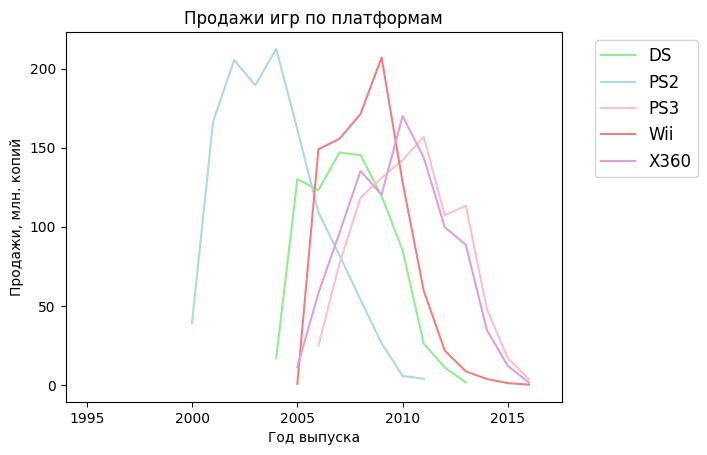

In [64]:
top_platforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
filtered_data = data[data['platform'].isin(top_platforms)]

platform_sales = filtered_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
ax = platform_sales.plot(color=['lightgreen', 'lightblue', 'pink', 'lightcoral', 'plum'])
ax.set_xlim(left=1994)

ax.set_xlabel('Год выпуска')
ax.set_ylabel('Продажи, млн. копий')
ax.set_title('Продажи игр по платформам')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 12})
plt.show()

В данных нет значений для 1993 и 1994 годов по top_platforms. График начинаеться с первого года, для которого есть данные.

Проанализируем данные о продажах игр по платформам и годам:

Тенденция продаж по годам:
Данные охватывают продажи с 1980 по 2016 год.
В целом наблюдается снижение продаж для старых платформ, таких как SAT, SCD, SNES, TG16, WS и XB. Это вполне ожидаемо, поскольку эти платформы были активны в более ранние годы и были вытеснены более новыми платформами.
Платформы, вышедшие относительно недавно (PS3, PS4, PSP, PSV, Wii, WiiU, X360, XB, XOne), имеют более высокие средние продажи по сравнению со старыми платформами.
Платформенные показатели (на основе среднего значения total_sales):
Платформы PS4, X360 и PS3 имеют самые высокие средние продажи, что говорит о том, что они являются наиболее популярными и успешными платформами с точки зрения продаж игр.
Платформы TG16, SCD, WS, SAT, PSV и XB имеют относительно более низкие средние продажи, что говорит о том, что они, возможно, не столь успешны с коммерческой точки зрения.
Разброс продаж по платформам (на основе стандартного отклонения total_sales):
Платформы с более высокими стандартными отклонениями, такие как PS3, PS4 и X360, характеризуются большей вариативностью продаж, что говорит о более широком диапазоне продаж игр для этих платформ.
Платформы с более низкими стандартными отклонениями, такие как WS, SAT, TG16 и SNES, имеют более стабильные продажи, что означает, что продажи игр для них более стабильны.
Продажи в зависимости от года выпуска:
В среднем суммарные продажи новых платформ выше, чем старых, что вполне ожидаемо, поскольку игровая индустрия со временем развивается и привлекает все больше потребителей.
Самые продаваемые игры:
Данные не содержат конкретной информации об отдельных играх, но было бы важно проанализировать самые продаваемые игры для каждой платформы.
Жизненный цикл платформы:
Некоторые платформы, такие как PS3, X360 и Wii, имеют относительно долгую историю продаж, что, вероятно, связано с их длительным жизненным циклом, в то время как у других он короче, что и сказывается на их общих продажах.
Доля рынка:
Для получения дополнительной информации было бы полезно сравнить долю рынка каждой платформы с течением времени. Это поможет понять относительное доминирование различных платформ в игровой индустрии.
Факторы, зависящие от конкретной платформы:
Успех каждой платформы зависет от различных факторов, таких как эксклюзивные игры, аппаратные возможности, цена, маркетинговые усилия и конкуренция со стороны других платформ.

Узнаем за какой характерный срок появляются новые и исчезают старые платформы.

Вычисляем время жизни каждой платформы (разницу между максимальным и минимальным годом выпуска игр).

In [65]:
platform_lifetimes = data.groupby('platform')['year_of_release'].agg(lambda x: x.max() - x.min())
mean_lifetime = platform_lifetimes.mean()
median_lifetime = platform_lifetimes.median()
max_lifetime = platform_lifetimes.max()
min_lifetime = platform_lifetimes.min()

print(f"Среднее время жизни платформы: {mean_lifetime:.1f} лет")
print(f"Медианное время жизни платформы: {median_lifetime:.1f} лет")
print(f"Максимальное время жизни платформы: {max_lifetime:.1f} лет")
print(f"Минимальное время жизни платформы: {min_lifetime:.1f} лет")

Среднее время жизни платформы: 9.0 лет
Медианное время жизни платформы: 9.0 лет
Максимальное время жизни платформы: 31.0 лет
Минимальное время жизни платформы: 0.0 лет


В среднем платформы существуют около 9 лет, прежде чем появляются новые и старые исчезают.

Проведем анализ продаж по жанрам и рейтингам.

<ipython-input-66-cf66fa6e6b9b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_sales = data.groupby('genre').sum().sum(axis=1)


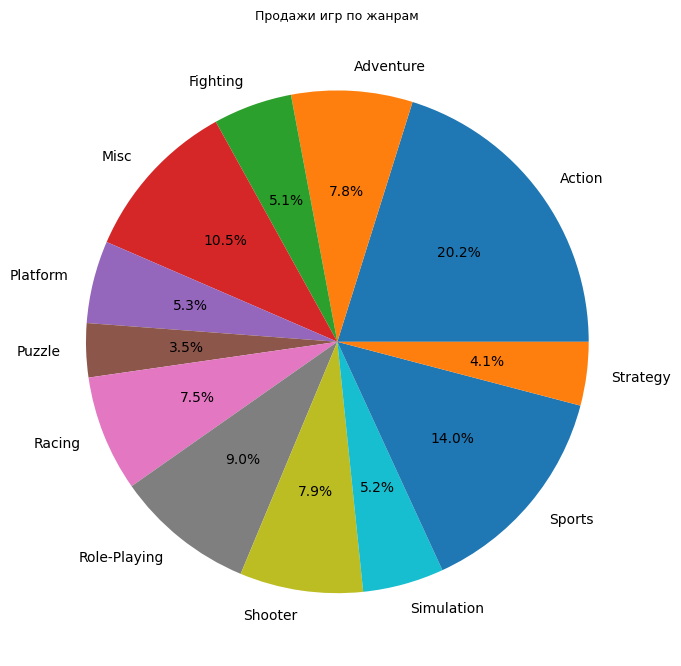

In [66]:
genre_sales = data.groupby('genre').sum().sum(axis=1)
fig, ax = plt.subplots(figsize=(7, 7))
genre_sales.plot.pie(ax=ax, labels=genre_sales.index, autopct='%.1f%%')
ax.set_title('Продажи игр по жанрам', fontsize=9)
plt.tight_layout()
plt.show()

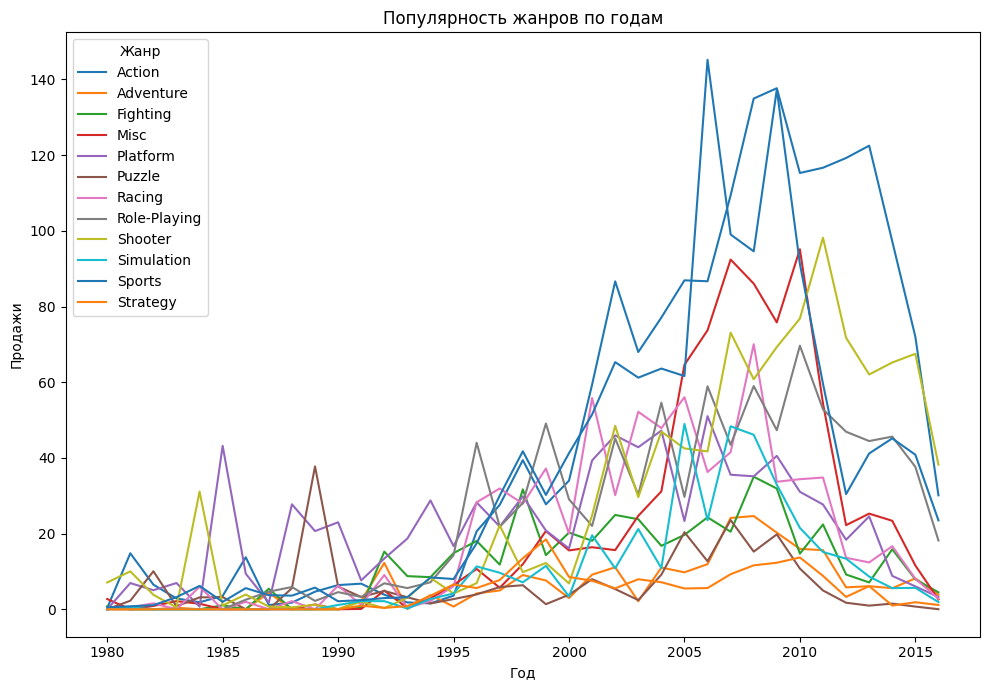

In [67]:
original_data = data.copy()
sales_data = original_data.pivot_table(index=['genre', 'rating'], columns='year_of_release', values='total_sales', aggfunc='sum')
sales_data = sales_data.reset_index()
sales_data = sales_data.melt(id_vars=['genre', 'rating'], var_name='year_of_release', value_name='total_sales')

genre_year_sales = sales_data.groupby(['genre', 'year_of_release']).sum().reset_index()
fig, ax = plt.subplots(figsize=(10, 7))

for genre, data in genre_year_sales.groupby('genre'):
    data.plot(x='year_of_release', y='total_sales', ax=ax, label=genre)

ax.set_title('Популярность жанров по годам', fontsize=12)
ax.set_xlabel('Год')
ax.set_ylabel('Продажи')
plt.legend(title='Жанр')
plt.tight_layout()
plt.show()

Сначала кадр данных `sales_data группируется по `жанрам`, и продажи суммируются по каждому жанру.  Посмотрев на размер каждой секции, можно быстро понять, в жанрах Sports и Action продажи самые высокие, а в Strategy, Puzzle - самые низкие. Эта информация будет полезна при принятии бизнес-решений на какие жанры ориентироваться при разработке новых игр или планировании рекламных кампаний.

Построим тепловую карту продаж по жанру и рейтингу.

<ipython-input-68-85025dee147f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rating_genre_sales = sales_data.groupby(['rating', 'genre']).sum().sum(axis=1)
<ipython-input-68-85025dee147f>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.pivot('rating', 'genre', 'sales')


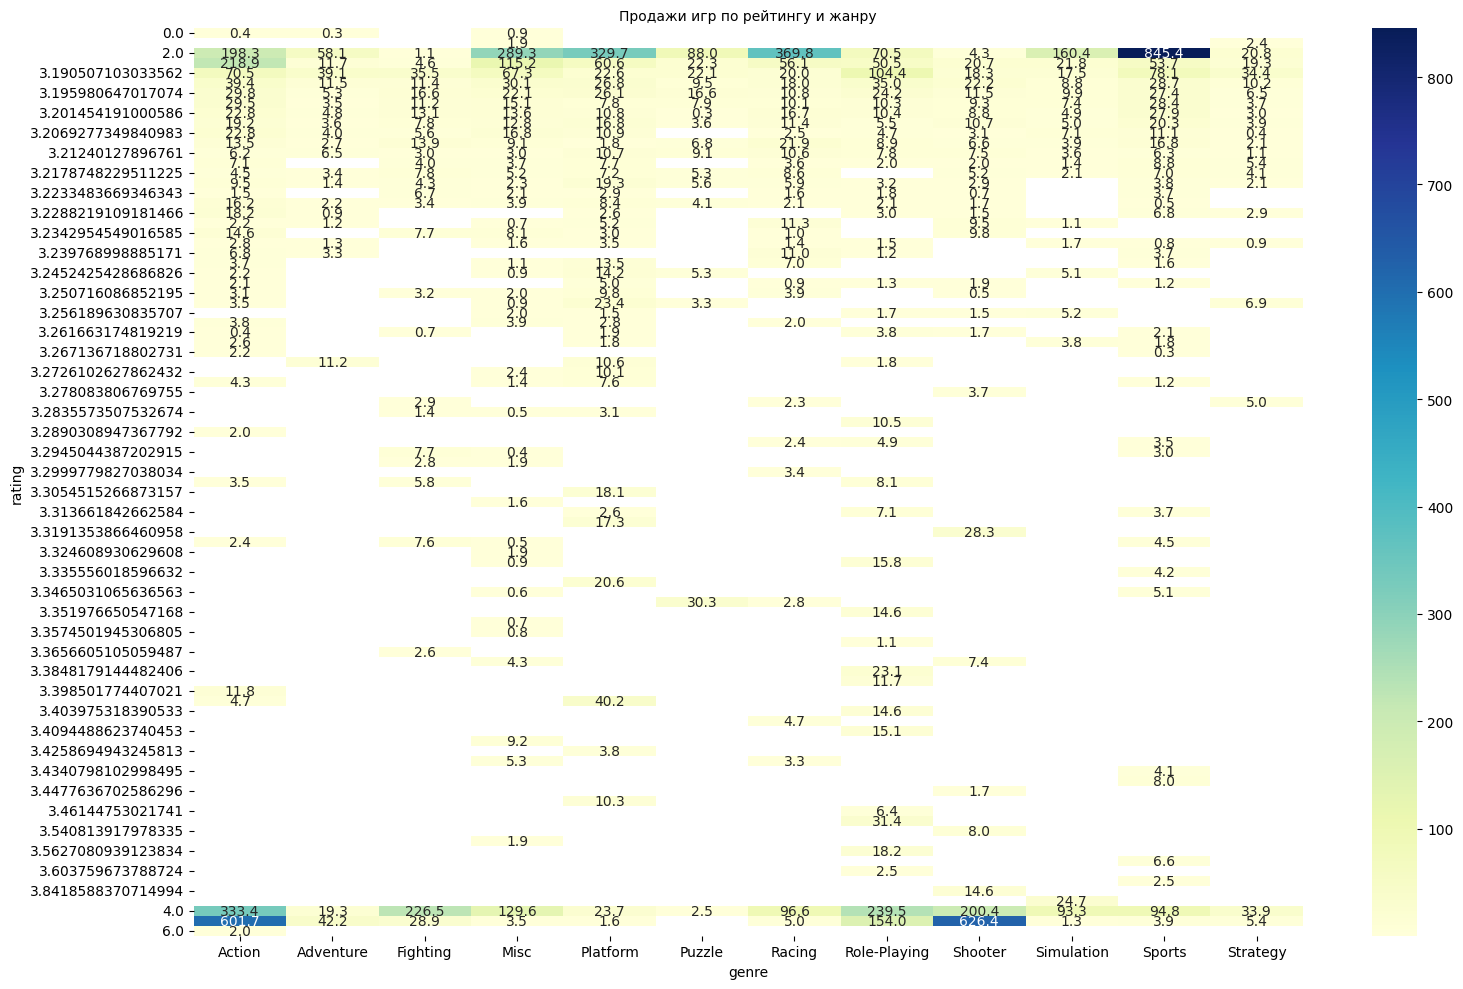

In [68]:
rating_genre_sales = sales_data.groupby(['rating', 'genre']).sum().sum(axis=1)
data = rating_genre_sales.reset_index()
data.columns = ['rating', 'genre', 'sales']
data = data.pivot('rating', 'genre', 'sales')

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.1f', ax=ax)
ax.set_title('Продажи игр по рейтингу и жанру', fontsize=10)
plt.tight_layout()
plt.show()

Ось x обозначена как "Рейтинг", а ось y - как "Продажи". Каждая ячейка на тепловой карте представляет собой продажи для определенного рейтинга. Цвет ячейки указывает на величину продаж: синий цвет обозначает более высокие продажи, а желтый - более низкие.

Тепловая карта показывает, что Action и Shooter c возрастным рейтингом 5 имеют более высокие продажи, чем другие, что является полезной информацией для принятия бизнес-решений.

С 1980 по 1991 годы популярными жанрами были Action, Platform, Puzzle, Shooter и Sports.

С 1990-х по 2000-й годы популярностью пользовались жанры Action, Adventure, Fighting, Shooter, Racing, Puzzle, Sports и Misc.

С 2000 года и до наших дней популярными жанрами являются Action, Fighting, Sports, Adventure, Shooter и Misc.

С развитием графики мы видим, как жанры Platform и Puzzle становятся менее востребованными.

В продажах лидируют игры с возрастным рейтингом Mature, Everyone и Everyone  10 and.

Суммарные продажи игр увеличиваются с течением времени.

Средние продажи игр также увеличились с течением времени, хотя и не так значительно, как суммарные продажи. Рынок игр становится все более насыщенным, и конкуренция между играми усиливается.

Стандартное отклонение продаж игр также увеличивается с течением времени. Это указывает на большее разнообразие в продажах игр и на то, что некоторые игры продаются лучше, чем другие.

Медиана продаж игр остается относительно стабильной с течением времени. Это указывает на то, что хотя некоторые игры продаются очень хорошо, большинство игр имеют средние продажи, которые не меняются значительно с течением времени.

В целом, эти данные показывают, что рынок игр растет и меняется. Продажи игр увеличиваются, но конкуренция между играми также усиливается.

Возьмем данные для прогноза суммарных продаж.

In [69]:
original_data = original_data[original_data['year_of_release'] >= 2015]

sales_data = original_data.groupby('year_of_release')['total_sales'].sum()
print(sales_data)

n = len(sales_data)
index = pd.date_range(start='2015', end='2017', freq='A')
sales = pd.Series(sales_data.values, index=index)

model = ExponentialSmoothing(sales, trend='add')
fit = model.fit()

forecast = fit.forecast(1)
print(forecast)


year_of_release
2015    267.98
2016    129.94
Name: total_sales, dtype: float64
2017-12-31   -8.099985
Freq: A-DEC, dtype: float64


Модель «Экспоненциальное сглаживание» с аддитивным трендом не подходит для данных. В модели предполагается, что тренд (т. е. изменение объемов продаж от года к году) остается постоянным во времени. В этом случае тенденция является отрицательной, поскольку продажи снизились с 2015 по 2016 год. Затем модель экстраполирует эту тенденцию, чтобы спрогнозировать дальнейшее снижение продаж на 2017 год, что приводит к отрицательному прогнозу.

Один из способов избежать негативных прогнозов — использовать другой метод прогнозирования, не предполагающий постоянную тенденцию. Например, использовать простое среднее или скользящее среднее для прогнозирования общего объема продаж на 2017 год.Этот метод не предполагает постоянную тенденцию и не дает отрицательных прогнозов.

In [70]:
original_data = original_data[original_data['year_of_release'] >= 2015]

sales_data = original_data.groupby('year_of_release')['total_sales'].sum()
print(sales_data)

# Рассчитываем 2-периодную скользящую среднюю
moving_avg = sales_data.rolling(window=2).mean()

forecast = moving_avg.iloc[-1]
print(forecast)

year_of_release
2015    267.98
2016    129.94
Name: total_sales, dtype: float64
198.96


Прогнозируемое значение на следующий год составляет 198,96 миллионов проданных копий, что является средним значением общего объема продаж за 2015 и 2016 годы. Это очень простой метод прогнозирования, который не дает точных результатов, так как наши данные имеют тренд, но в сравнении его с другими прогнозами, полученными с использованием других методов и моделей, более правдоподобен.

Проанализируем данные о продажах игр по платформам.

In [71]:
top_platforms = original_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
print(top_platforms.head(7))

platform
PS4     188.15
XOne     86.29
3DS      42.92
WiiU     20.95
PS3      20.42
PC       13.77
X360     13.48
Name: total_sales, dtype: float64


Вывод показывает 7 самых прибыльных платформ в порядке убывания общих продаж. Самой прибыльной платформой является PS4 с общими продажами в 188.15 млн копий, а самой менее прибыльной из первых семи является X360 с общими продажами в 13.48 млн копий.

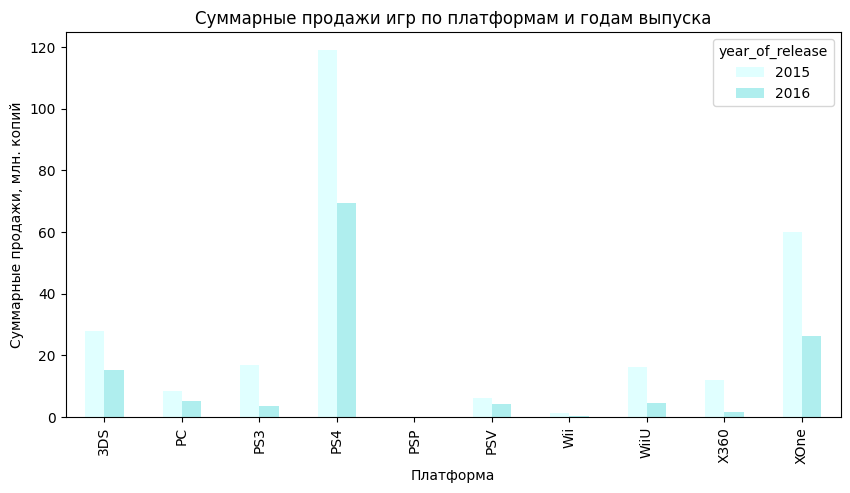

In [72]:
colors = ['lightcyan', 'paleturquoise', 'powderblue', 'lightblue', 'skyblue', 'lightskyblue']
sales_data = original_data.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
sales_data.plot(kind='bar', figsize=(10, 5), color=colors)
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи, млн. копий')
plt.title('Суммарные продажи игр по платформам и годам выпуска')
plt.show()

Самые высокие продажи были у платформы PS4 в 2015 году с более чем 120 миллионов копий.

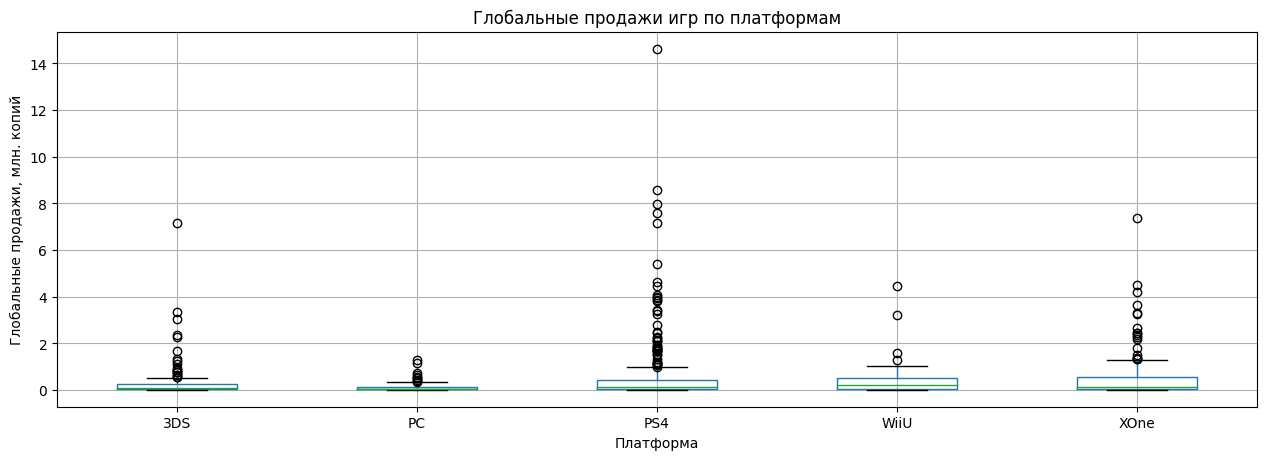

In [73]:
platforms = ['PS4', 'XOne', '3DS', 'WiiU', 'PC']
filtered_data = original_data[original_data['platform'].isin(platforms)]

filtered_data.boxplot(column='total_sales', by='platform', figsize=(15, 5))
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи, млн. копий')
plt.title('Глобальные продажи игр по платформам')
plt.suptitle('')
plt.show()

Платформы "PS4" и "XOne" имеют потенциал для более высоких суммарных продаж игр, в то время как платформы "3DS" и "WiiU" имеют более низкие суммарные продажи.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния, посчитаем корреляцию между отзывами и продажами.

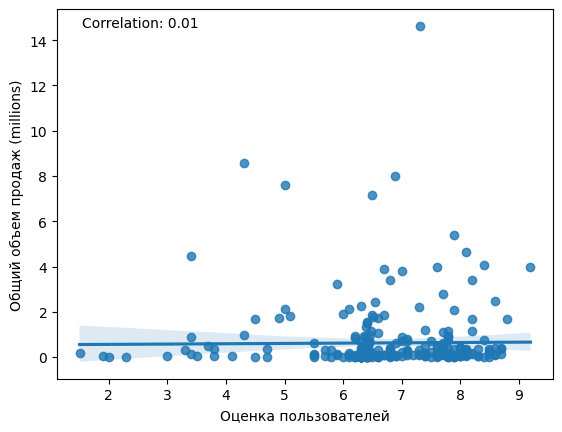

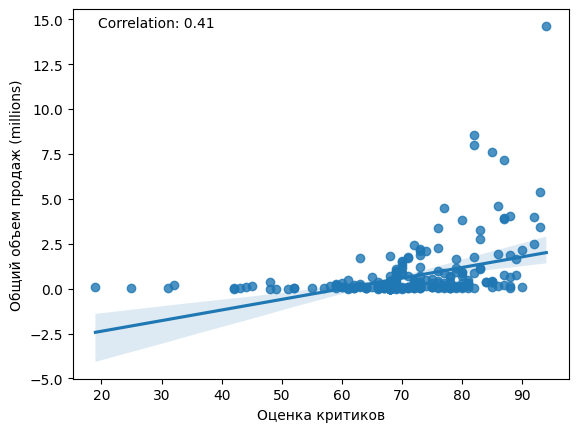

In [74]:
ps4_data = original_data.query('platform == "PS4"')

ps4_data = ps4_data.dropna(subset=['user_score', 'critic_score', 'total_sales'])

corr_matrix = ps4_data[['user_score', 'critic_score', 'total_sales']].corr()

sns.regplot(x='user_score', y='total_sales', data=ps4_data)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общий объем продаж (millions)')

corr_value = corr_matrix.loc['user_score', 'total_sales']
corr_text = f'Correlation: {corr_value:.2f}'

plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes)
plt.show()

ps4_data['critic_score'] = ps4_data['critic_score'].astype(float)
ps4_data['total_sales'] = ps4_data['total_sales'].astype(float)
sns.regplot(x='critic_score', y='total_sales', data=ps4_data)
plt.xlabel('Оценка критиков')
plt.ylabel('Общий объем продаж (millions)')

corr_value = corr_matrix.loc['critic_score', 'total_sales']
corr_text = f'Correlation: {corr_value:.2f}'
plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes)

plt.show()


Коэффициент корреляции между оценкой пользователей и общим объемом продаж составляет 0.01. Между оценкой пользователей и общим объемом продаж практически нет связи.

Коэффициент корреляции между оценкой критиков и общим объемом продаж составляет 0.41. Это указывает на умеренную положительную корреляцию между этими двумя переменными. С увеличением оценки критиков общий объем продаж также может увеличиваться.

Посмотрим, как влияют на продажи других платформ отзывы пользователей и критиков.

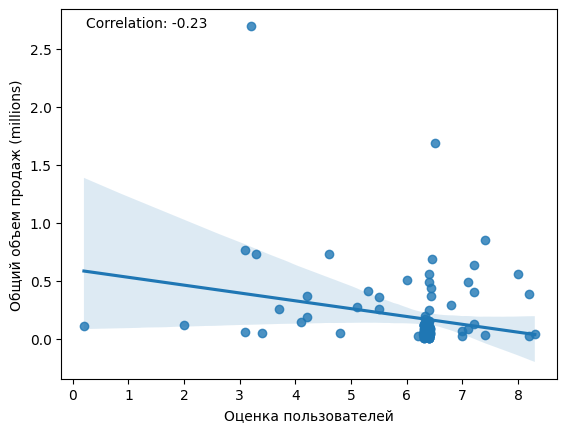

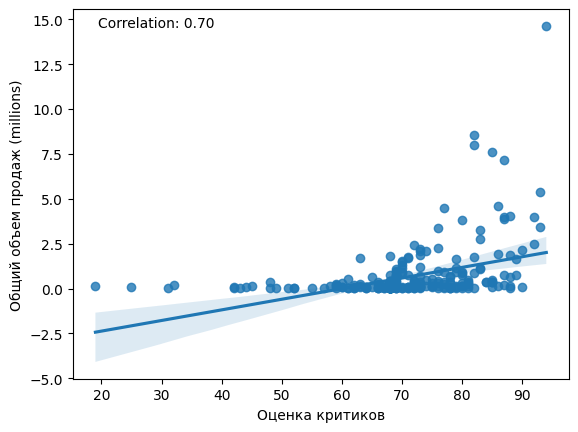

In [75]:
ps3_data = original_data.query('platform == "PS3"')

ps3_data = ps3_data.dropna(subset=['user_score', 'critic_score', 'total_sales'])

corr_matrix = ps3_data[['user_score', 'critic_score', 'total_sales']].corr()

sns.regplot(x='user_score', y='total_sales', data=ps3_data)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общий объем продаж (millions)')

corr_value = corr_matrix.loc['user_score', 'total_sales']
corr_text = f'Correlation: {corr_value:.2f}'

plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes)
plt.show()

ps3_data['critic_score'] = ps3_data['critic_score'].astype(float)
ps3_data['total_sales'] = ps3_data['total_sales'].astype(float)
sns.regplot(x='critic_score', y='total_sales', data=ps4_data)
plt.xlabel('Оценка критиков')
plt.ylabel('Общий объем продаж (millions)')

corr_value = corr_matrix.loc['critic_score', 'total_sales']
corr_text = f'Correlation: {corr_value:.2f}'
plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes)

plt.show()

Коэффициент корреляции между оценкой пользователей и общим объемом продаж составляет -0.23. Это указывает на слабую отрицательную корреляцию между этими двумя переменными. С увеличением оценки пользователей общий объем продаж может немного уменьшаться. Однако, так как корреляция слабая, эта связь не является сильной и может быть объяснена другими факторами.

Коэффициент корреляции между оценкой критиков и общим объемом продаж составляет 0.70. Это указывает на умеренную положительную корреляцию между этими двумя переменными. Это означает, что с увеличением оценки критиков общий объем продаж также может увеличиваться.

Корреляция между оценками критиков и продажами по платформам разная, это связано с различными факторами, такими как аудитория платформы, типы игр, которые популярны на платформе, и маркетинговые стратегии компаний, выпускающих игры.

PS_4 - более популярная платформа и имеет более широкую аудиторию, поэтому оценки критиков меньше влияют на продажи. Большее количество людей покупают игры на этой платформе независимо от оценок критиков. PS_3 - менее популярная платформа и имеет более узкую аудиторию, которая больше полагается на оценки критиков при выборе игр.

In [76]:
platform_data = original_data.query('platform == "PS3"')

best_selling_game = platform_data.loc[platform_data['total_sales'].idxmax()]

game_name = best_selling_game['name']
game_genre = best_selling_game['genre']

print(f'Самая продаваемая игра на платформе PS3 - {game_name} в жанре {game_genre}')

Самая продаваемая игра на платформе PS3 - FIFA 16 в жанре Sports


In [77]:
platform_data = original_data.query('platform == "PS4"')

best_selling_game = platform_data.loc[platform_data['total_sales'].idxmax()]

game_name = best_selling_game['name']
game_genre = best_selling_game['genre']

print(f'Самая продаваемая игра на платформе PS4 - {game_name} в жанре {game_genre}')

Самая продаваемая игра на платформе PS4 - Call of Duty: Black Ops 3 в жанре Shooter


### Шаг 4. Составим портрет пользователя каждого региона


Чтобы понять, как рейтинг ESRB влияет на продажи в каждом регионе, мы можем сгруппировать данные по регионам и рейтингу ESRB и посчитать сумму продаж для каждой группы.

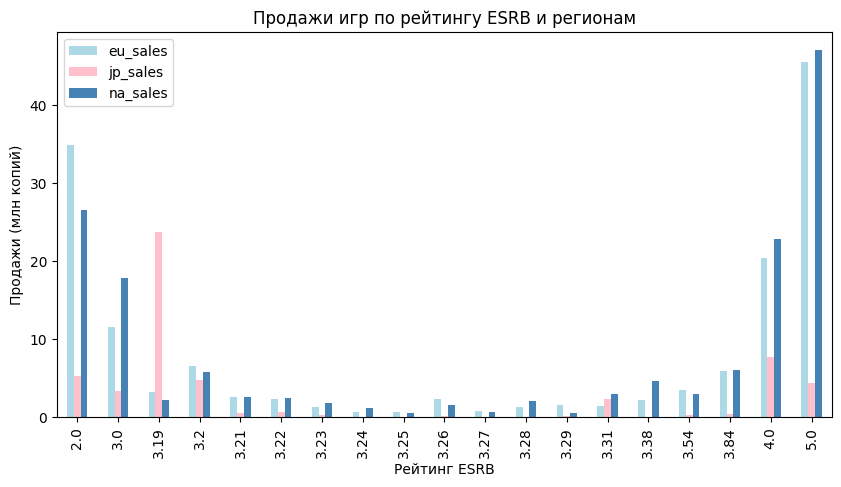

In [78]:
original_data['rating'] = original_data['rating'].round(2)
sales_by_region_rating = original_data.pivot_table(
    index='rating',
    values=['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc='sum'
)

colors = ['lightblue', 'pink', 'steelblue']
sales_by_region_rating.plot(kind='bar', figsize=(10, 5), color=colors)
plt.title('Продажи игр по рейтингу ESRB и регионам')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи (млн копий)')
plt.show()

На графике ось x показывает рейтинг ESRB, а ось y - продажи в миллионах. Для каждого рейтинга на графике есть три столбца: для Европы (EU), для Японии (JP) и для Северной Америки (NA).

Наивысшие продажи игр наблюдаются с рейтингом 5.0 в Северной Америке, за которыми следуют игры с рейтингом 4.0 в Европе.

Наименьшие продажи наблюдаются для игр с рейтингом 2.0 в Японии.

In [79]:
region = 'na_sales'

platform_sales = original_data.groupby('platform')[region].sum()

top_platform = platform_sales.sort_values(ascending=False).head(5)

print(f'Самая популярная платформа в регионе {region}:')
print(top_platform)

genre_sales = original_data.groupby('genre')[region].sum()

top_genre = genre_sales.sort_values(ascending=False).head(5)

print(f'Самый популярный жанр в регионе {region}:')
print(top_genre)

Самая популярная платформа в регионе na_sales:
platform
PS4     63.86
XOne    50.30
3DS     10.31
WiiU     8.86
X360     8.05
Name: na_sales, dtype: float64
Самый популярный жанр в регионе na_sales:
genre
Shooter         48.18
Action          33.68
Sports          26.31
Role-Playing    19.82
Misc             5.58
Name: na_sales, dtype: float64


In [80]:
region = 'eu_sales'
platform_sales = original_data.groupby('platform')[region].sum()
top_platform = platform_sales.sort_values(ascending=False).head(5)

print(f'Самая популярная платформа в регионе {region}:')
print(top_platform)

genre_sales = original_data.groupby('genre')[region].sum()
top_genre = genre_sales.sort_values(ascending=False).head(5)

print(f'Самый популярный жанр в регионе {region}:')
print(top_genre)

Самая популярная платформа в регионе eu_sales:
platform
PS4     83.54
XOne    28.10
PC       9.10
3DS      7.39
PS3      7.30
Name: eu_sales, dtype: float64
Самый популярный жанр в регионе eu_sales:
genre
Shooter         40.28
Action          34.82
Sports          27.82
Role-Playing    17.21
Racing           6.52
Name: eu_sales, dtype: float64


In [81]:
region = 'jp_sales'
platform_sales = original_data.groupby('platform')[region].sum()
top_platform = platform_sales.sort_values(ascending=False).head(5)

print(f'Самая популярная платформа в регионе {region}:')
print(top_platform)

genre_sales = original_data.groupby('genre')[region].sum()
top_genre = genre_sales.sort_values(ascending=False).head(5)

print(f'Самый популярный жанр в регионе {region}:')
print(top_genre)

Самая популярная платформа в регионе jp_sales:
platform
3DS     23.55
PS4     12.05
PSV      8.41
PS3      4.97
WiiU     4.12
Name: jp_sales, dtype: float64
Самый популярный жанр в регионе jp_sales:
genre
Action          23.05
Role-Playing    13.41
Shooter          3.79
Misc             3.19
Adventure        2.22
Name: jp_sales, dtype: float64


В Европе самой популярной платформой является PS4, а самым популярным жанром - шутеры.
В Японии самой популярной платформой является 3DS, а самым популярным жанром - экшн.
В Северной Америке самой популярной платформой является PS4, а самым популярным жанром - шутеры.
Мы можем видеть, что в Европе и Северной Америке предпочтения игроков схожи: оба региона предпочитают платформу PS4 и жанр шутеров. Однако, в Японии предпочтения игроков отличаются: самой популярной платформой является 3DS, а самым популярным жанром - экшн. Это обусловлено разницей культур. Японцы известны своей экономностью и умением рационально расходовать ресурсы. Они также имеют культуру сбережения и предпочитают планировать свои расходы заранее. Эти качества могут объяснять отличие в выборе.

Рассчитаем процентную разницу в продажах между лидирующими платформами в каждом регионе.

In [82]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

for region in regions:

    platform_sales = original_data.groupby('platform')[region].sum()
    top_platforms = platform_sales.sort_values(ascending=False).head(5)

    sales_difference = top_platforms.iloc[0] - top_platforms.iloc[1]
    percent_difference = (sales_difference / top_platforms.iloc[0]) * 100

    print(f'Процентная разница в продажах между лидирующими платформами в регионе {region}: {percent_difference:.2f}%')

Процентная разница в продажах между лидирующими платформами в регионе na_sales: 21.23%
Процентная разница в продажах между лидирующими платформами в регионе eu_sales: 66.36%
Процентная разница в продажах между лидирующими платформами в регионе jp_sales: 48.83%


Видим, что у европейцев существует общая тенденция в отношении выбора игровых платформ и жанров.

### Шаг 5. Проверим гипотезу

Проверим гипотезы t-критерием Стьюдента для независимых выборок.

Отбирем данные по платформам Xbox One и PC, проверим нормальность распределения и равенство дисперсий, применим t-критерий.

Нулевая гипотеза звучит так: 'Нет оснований считать средние пользовательские рейтинги платформ Xbox One и PC различными'. Альтернативная гипотеза: 'Средние пользовательские рейтинги платформ Xbox One и PC различны'.

In [83]:
xbox_one = original_data.query('platform == "XOne"')['user_score']
pc = original_data.query('platform == "PC"')['user_score']


# Применение t-критерия Стьюдента
result = stats.ttest_ind(xbox_one, pc, equal_var=False)
print('p-значение:', result.pvalue)

alpha = 0.05

if result.pvalue < alpha:
    print('Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различны')
else:
    print('Нулевая гипотеза: нет оснований считать средние пользовательские рейтинги платформ Xbox One и PC различными')


p-значение: 0.3080696849325115
Нулевая гипотеза: нет оснований считать средние пользовательские рейтинги платформ Xbox One и PC различными


Применим критерий Манна-Уитни для сравнения средних пользовательских рейтингов жанров Action и Sports, так как распределения пользовательских рейтингов для обоих жанров не нормальные.

Нулевая гипотеза для теста выглядит так: 'Нет оснований считать средние пользовательские рейтинги жанров Action и Sports различными'.

Альтернативная гипотеза: 'Средние пользовательские рейтинги жанров Action и Sports различны'.

In [84]:
action = original_data.query('genre == "Action"')['user_score']
sports = original_data.query('genre == "Sports"')['user_score']

result = stats.mannwhitneyu(action, sports)
print('p-значение:', result.pvalue)

alpha = 0.05

if result.pvalue < alpha:
    print('Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports различны')
else:
    print('Нулевая гипотеза: нет оснований считать средние пользовательские рейтинги жанров Action и Sports различными')


p-значение: 6.213099420344547e-11
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports различны


Для обеих гипотез я задала пороговое значение alpha равным 0.05. Это стандартное значение alpha, которое часто используется в статистических тестах.

### Шаг 6. Общий вывод

Для исследования рынка компьютерных игр и планирования рекламных кампаний мы использовали открытые данные о продажах, оценках и жанрах игр, а также возрастном рейтинге ESRB. Был проведен анализ базовой статистики, исследовательский анализ данных, анализ продаж по платформам и жанрам, а также проверили гипотезы о равенстве средних пользовательских рейтингов для разных платформ и жанров. Спрогнозировали продажи игр на 2017 год с помощью скользящего среднего значения.

Проектная работа показывает, что рынок игр растет и меняется. Продажи игр увеличиваются, но конкуренция между играми также усиливается. Отзывы критиков имеют слабое положительное влияние на продажи, а отзывы пользователей не имеют значительного влияния. Средние пользовательские рейтинги жанров Action, Shooter и Sports лидируют статистически значимо.

Рекомендации при выборе продукта для акцентирования и планирования рекламных акций:

Сосредоточьтесь на платформах с наибольшими суммарными продажами, таких как PS4, X360, XOne, PS3, Wii и 3DS.

Рассмотрите жанры Action, Sports и Shooter, так как они являются самыми популярными.

Учитывайте возрастной рейтинг ESRB при выборе игр для продвижения, так как он влияет на продажи игр.

Обратите внимание на отзывы критиков, так как они имеют положительное влияние на продажи игр на менее популярных платформах.

Адаптируйте свою рекламную кампанию под каждую страну. Предпочтения игроков могут отличаться в зависимости от культуры, языка и других факторов. Используйте местные языки и культурные особенности для создания эффективной рекламной кампании, которая привлечет внимание местных игроков.
Сотрудничайте с местными партнерами. Местные партнеры, такие как дистрибьюторы или рекламные агентства, могут помочь вам лучше понять местный рынок и спланировать эффективную рекламную кампанию.

Ваша рекламная кампания может включать в себя различные мероприятия, такие как реклама в социальных сетях, реклама на тематических сайтах и форумах, участие в игровых выставках и конференциях, проведение конкурсов и акций. Главное - выбрать правильный продукт для акцентирования и правильно спланировать рекламные акции, учитывая закономерности и тенденции на рынке компьютерных игр.